# Testing anomaly detection algorithms on KDDCUP99
The 1998 DARPA Intrusion Detection Evaluation Program was prepared and managed by MIT Lincoln Labs. The objective was to survey and evaluate research in intrusion detection.  A standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment, was provided.  The 1999 KDD intrusion detection contest uses a version of this dataset.

We will evaluate the performance of unsupervised learning algorithms such as Isolation Forest, Local Outlier Factor, Support Vector Machines and DBSCAN against this dataset. Mainly in term of accuracy, runtime and memory consumption.


In [1]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [2]:
def byte_decoder(val):
    # decodes byte literals to strings
    
    return val.decode('utf-8')

def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'],
                          cmap=plt.cm.Reds):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def time(expr):
    start = datetime.datetime.now()
    code = eval(expr)
    end = datetime.datetime.now()
    return (end-start, code)

sa_columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
                           "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
                           "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
                           "is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
                           "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
                           "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
                           "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
                           "dst_host_rerror_rate","dst_host_srv_rerror_rate"]
sf_columns = ["duration", "service", "src_bytes", "dst_bytes"]

# KDDCUP99 SF data set
`SF` is the a subset of the main dataset where the attribute logged_in is positive, thus focusing on the intrusion attack, which gives an anomaly ratio 0.3%. SF has log-transformed 4 attributes.

In [3]:
sf = datasets.fetch_kddcup99(subset='SF', percent10=False, random_state=0)
dfsf = pd.DataFrame(sf.data, columns=sf_columns)
dfsf["target"]=sf.target
anomaly_rate_sf = 1.0 - len(dfsf.loc[dfsf["target"]==b'normal.'])/len(dfsf)
f"SF anomaly rate is {anomaly_rate_sf:.1%}"

'SF anomaly rate is 0.5%'


## Data preprocessing for SF
The preprocessing step consists of :
* Encode categorical attributes to numerical using a Label encoder
* Strip the data of its label for unsupervised learning
* Normalize the numerical attributes

In [4]:
dfsf['binary_target'] = [1 if x==b'normal.' else -1 for x in dfsf["target"]]
toDecodeSF = ["service", "target"]    
leSF = preprocessing.LabelEncoder()
for f in toDecodeSF:
    dfsf[f] = list(map(byte_decoder, dfsf[f]))
    dfsf[f] = leSF.fit_transform(dfsf[f])

dfsf_normed = preprocessing.normalize(dfsf.drop(["target", 'binary_target'], axis=1))

## Initializing algorithms

In [5]:
num_extimators = 100
max_samples = 0.2
contamination = 0.15
eps = 0.25

ifsf = IsolationForest(max_samples=0.25, random_state=1, contamination = contamination, n_estimators=100, n_jobs=-1)
lofsf = LocalOutlierFactor(n_neighbors=15, metric='euclidean', algorithm = 'auto', contamination=0.05, n_jobs=-1)
ocsvm = OneClassSVM(nu=contamination, kernel="rbf",gamma=0.1)
dbscan = DBSCAN(eps=eps, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1)

In [6]:
X_sf = dfsf.drop(["target", 'binary_target'], axis=1)
y_sf = dfsf["binary_target"]

In [7]:
fit_time_if_sf, Y_pred_sf_if  = time(expr = "ifsf.fit_predict(X_sf)")
print(f"Trainning If finished in {fit_time_if_sf}")
cm_sf_if = confusion_matrix(y_sf, Y_pred_sf_if)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Trainning If finished in 0:01:25.845672


In [8]:
fit_time_lof_sf, Y_pred_sf_lof  = time(expr = "lofsf.fit_predict(X_sf)")
print(f"Trainning lof finished in {fit_time_lof_sf}")
cm_sf_lof = confusion_matrix(y_sf, Y_pred_sf_lof)

Trainning lof finished in 0:05:52.508292


In [ ]:
fit_time_svm_sf, Y_pred_sf_svm  = time(expr = "ocsvm.fit_predict(X_sf)")
print(f"Trainning svm finished in {fit_time_svm_sf}")
cm_sf_svm = confusion_matrix(y_sf, Y_pred_sf_svm)

In [ ]:
fit_time_dbscan_sf, db  = time(expr = "dbscan.fit(X_sf)")
print(f"Trainning dbscan finished in {fit_time_dbscan_sf}")
labels = db.labels_
y_pred_sf_dbscan = [1 if i != -1 else i for i in labels]
cm_sf_dbscan = confusion_matrix(y_sf, y_pred_sf_dbscan)

              precision    recall  f1-score   support

     anomaly       0.03      1.00      0.06      3377
      normal       1.00      0.85      0.92    699690

   micro avg       0.85      0.85      0.85    703067
   macro avg       0.52      0.93      0.49    703067
weighted avg       1.00      0.85      0.92    703067

AUC:  92.7%


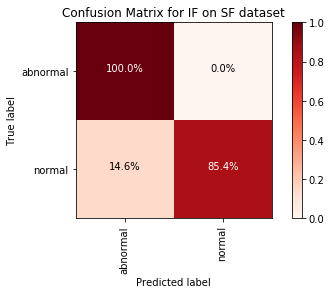

In [9]:
print(classification_report(y_sf, Y_pred_sf_if, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_sf, Y_pred_sf_if)))
plot_confusion_matrix(cm_sf_if, "Confusion Matrix for IF on SF dataset")

              precision    recall  f1-score   support

     anomaly       0.00      0.01      0.00      3377
      normal       0.99      0.95      0.97    699690

   micro avg       0.95      0.95      0.95    703067
   macro avg       0.50      0.48      0.49    703067
weighted avg       0.99      0.95      0.97    703067

AUC:  47.8%


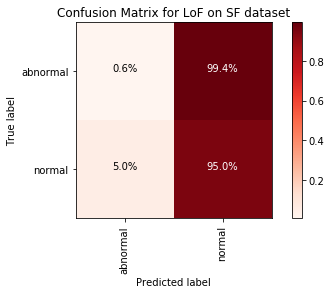

In [10]:
print(classification_report(y_sf, Y_pred_sf_lof, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_sf, Y_pred_sf_lof)))
plot_confusion_matrix(cm_sf_lof, "Confusion Matrix for LoF on SF dataset")

In [ ]:
print(classification_report(y_sf, Y_pred_sf_svm, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_sf, Y_pred_sf_svm)))
plot_confusion_matrix(cm_sf_svm, "Confusion Matrix for SVM on SF dataset")

In [ ]:
print(classification_report(y_sf, y_pred_sf_dbscan, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_sf, y_pred_sf_dbscan)))
plot_confusion_matrix(cm_sf_dbscan, "Confusion Matrix for DBSCAN on SF dataset")

## Evaluating the algorithms on classifying new data
Frequently we have to classify whether a not a banking transaction or a network traffic is an anomaly in realtime. To evaluate this capabilities, we'll split the dataset into a train and a test set. Our algorithms will train on the train set and then classify the test set

In [ ]:
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.33, random_state=0)
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(dfsf_normed, dfsf['binary_target'], test_size=0.33, random_state=0)

### SF train set

In [ ]:
start = datetime.datetime.now()
y_pred_train_if_sf = ifsf.fit_predict(X_train_sf)
end = datetime.datetime.now()
print(f"trainning finished in : {end-start} : {set(y_pred_train_if_sf)}")
cm_train_if_sf = confusion_matrix(y_train_sf, y_pred_train_if_sf)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


trainning finished in : 0:00:56.903824 : {1, -1}


In [ ]:
start = datetime.datetime.now()
y_pred_train_lof_sf = lofsf.fit_predict(X_train_sf)
end = datetime.datetime.now()
print(f"trainning finished in : {end-start} : {set(y_pred_train_lof_sf)}")
cm_train_lof_sf = confusion_matrix(y_train_sf, y_pred_train_lof_sf)

trainning finished in : 0:03:05.919662 : {1, -1}


In [ ]:
start = datetime.datetime.now()
y_pred_train_svm_sf = ocsvm.fit(X_train_sf).predict(X_train_sf)
end = datetime.datetime.now()
print(f"trainning finished in : {end-start} : {set(y_pred_train_svm_sf)}")
cm_train_svm_sf = confusion_matrix(y_train_sf, y_pred_train_svm_sf)

In [ ]:
start = datetime.datetime.now()
db = dbscan.fit(X_train_sf)
y_pred_train_dbscan_sf = [1 if i != -1 else i for i in db.labels_]
end = datetime.datetime.now()
print(f"trainning finished in : {end-start} : {set(y_pred_train_dbscan_sf)}")
cm_train_dbscan_sf = confusion_matrix(y_train_sf, y_pred_train_dbscan_sf)

              precision    recall  f1-score   support

     anomaly       0.03      1.00      0.06      2276
      normal       1.00      0.85      0.92    468778

   micro avg       0.85      0.85      0.85    471054
   macro avg       0.52      0.93      0.49    471054
weighted avg       1.00      0.85      0.92    471054

AUC:  92.7%


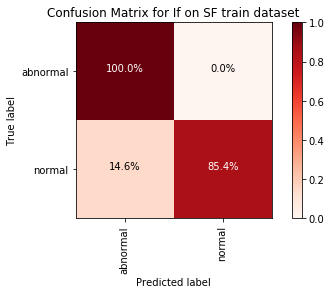

In [ ]:
print(classification_report(y_train_sf, y_pred_train_if_sf, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_sf, y_pred_train_if_sf)))
plot_confusion_matrix(cm_train_if_sf, "Confusion Matrix for If on SF train dataset")

              precision    recall  f1-score   support

     anomaly       0.00      0.02      0.00      2276
      normal       1.00      0.95      0.97    468778

   micro avg       0.95      0.95      0.95    471054
   macro avg       0.50      0.49      0.49    471054
weighted avg       0.99      0.95      0.97    471054

AUC:  48.5%


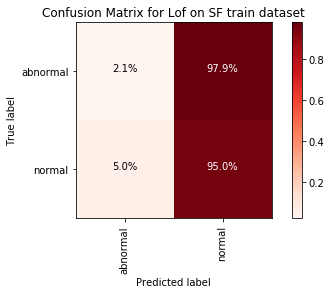

In [ ]:
print(classification_report(y_train_sf, y_pred_train_lof_sf, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_sf, y_pred_train_lof_sf)))
plot_confusion_matrix(cm_train_lof_sf, "Confusion Matrix for Lof on SF train dataset")

In [ ]:
print(classification_report(y_train_sf, y_pred_train_svm_sf, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_sf, y_pred_train_svm_sf)))
plot_confusion_matrix(cm_train_svm_sf, "Confusion Matrix for svm on SF train dataset")

In [ ]:
print(classification_report(y_train_sf, y_pred_train_dbscan_sf, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_sf, y_pred_train_dbscan_sf)))
plot_confusion_matrix(cm_train_dbscan_sf, "Confusion Matrix for dbscan on SF train dataset")

### SF test set


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


              precision    recall  f1-score   support

     anomaly       0.03      1.00      0.06      1101
      normal       1.00      0.85      0.92    230912

   micro avg       0.85      0.85      0.85    232013
   macro avg       0.52      0.93      0.49    232013
weighted avg       1.00      0.85      0.92    232013

AUC:  92.7%


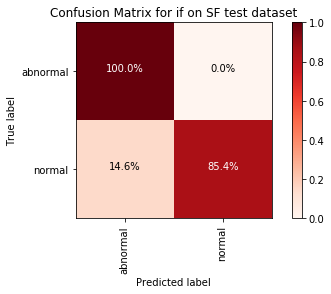

In [ ]:
y_pred_test_sf_if = ifsf.predict(X_test_sf)
print(classification_report(y_test_sf, y_pred_test_sf_if, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test_sf, y_pred_test_sf_if)))
cm_test_if_sf = confusion_matrix(y_test_sf, y_pred_test_sf_if)
plot_confusion_matrix(cm_test_if_sf, "Confusion Matrix for if on SF test dataset")

In [ ]:
X_clean_sf = X_train_sf.drop([index for i,index in enumerate(y_pred_train_lof_sf) if i==-1])
n_lof = LocalOutlierFactor(n_neighbors=15, metric='euclidean', algorithm = 'auto', contamination=contamination, novelty=True, n_jobs=-1)
n_lof.fit(X_clean_sf)

y_pred_test_sf_lof = n_lof.fit(X_clean_sf).predict(X_test_sf)
print(classification_report(y_test_sf, y_pred_test_sf_lof, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test_sf, y_pred_test_sf_lof)))
cm_test_lof_sf = confusion_matrix(y_test_sf, y_pred_test_sf_lof)
plot_confusion_matrix(cm_test_lof_sf, "Confusion Matrix for lof on SF test dataset")

In [ ]:
y_pred_test_sf_svm = ocsvm.predict(X_test_sf)
print(classification_report(y_test_sf, y_pred_test_sf_svm, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test_sf, y_pred_test_sf_svm)))
cm_test_svm_sf = confusion_matrix(y_test_sf, y_pred_test_sf_svm)
plot_confusion_matrix(cm_test_svm_sf, "Confusion Matrix for svm on SF test dataset")

In [ ]:
db = dbscan.fit_predict(X_test_sf)
y_pred_test_sf_db = [1 if i != -1 else i for i in db]
print(classification_report(y_test_sf, y_pred_test_sf_db, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test_sf, y_pred_test_sf_db)))
cm_test_dbscan_sf = confusion_matrix(y_test_sf, y_pred_test_sf_db)
plot_confusion_matrix(cm_test_dbscan_sf, "Confusion Matrix for dbscan on SF test dataset")

# KDDCUP SA dataset

`SA` is obtained by simply selecting all the normal data, and a small proportion of abnormal data to give an anomaly ratio of 1%. SA has all 41 attributes.

Similar to the `SF` dataset, unlabelled data are fed to the anomaly detection algorithms. The results are then compared with the original label to mesure performance.




In [4]:
sa = datasets.fetch_kddcup99(subset='SA', percent10=False)
dfsa=pd.DataFrame(sa.data, 
                  columns=sa_columns)
assert len(dfsa)>0, "SA dataset not loaded."
dfsa["target"]=sa.target
anomaly_rate_sa = 1.0 - len(dfsa.loc[dfsa["target"]==b'normal.'])/len(dfsa)
f"SA anomaly rate is {anomaly_rate_sa:.1%}"

EOFError: Ran out of input


## Data preprocessing for SA
The preprocessing step consists of :
* Encode categorical attributes to numerical using a Label encoder
* Strip the data of its label for unsupervised learning
* Normalize the numerical attributes

In [ ]:

toDecodeSA = ["protocol_type", "service", "flag", "target"]
dfsa["binary_target"] = [1 if x==b'normal.' else -1 for x in dfsa["target"]]    
leSF = preprocessing.LabelEncoder()
for f in toDecodeSA:
    dfsa[f] = list(map(byte_decoder, dfsa[f]))
    dfsa[f] = leSF.fit_transform(dfsa[f])
    
dfsa_normalized = preprocessing.normalize(dfsa.drop(["target", "binary_target"], axis=1))

X_train_sa, X_test_sa, Y_train_sa, Y_test_sa = train_test_split(dfsa.drop(["target", "binary_target"], axis=1), dfsa["binary_target"], test_size=0.33, random_state=0)
X_train_sa_normalized, X_test_sa_normalized, Y_train_sa_normalized, Y_test_sa_normalized = train_test_split(dfsa_normalized, dfsa["binary_target"], test_size=0.33, random_state=0)

In [ ]:
contamination = 0.2
max_samples = 0.25
n_estimator = 100
random_state = 12
n_neighbors = 15

If = IsolationForest(max_samples       = max_samples, 
                     contamination     = contamination, 
                     n_estimators      = n_estimator,
                     random_state      = random_state,
                     n_jobs            = -1)

Lof = LocalOutlierFactor(n_neighbors   = n_neighbors, 
                         metric        = 'euclidean', 
                         algorithm     = 'auto', 
                         contamination = contamination, 
                         n_jobs        = -1)

OCSVM = OneClassSVM(gamma              = 'auto',
                    verbose            = True)


In [ ]:
fit_time_if_sa, Y_pred_train_sa_if  = time(expr = "If.fit_predict(X_train_sa_normalized)")
print(f"Trainning If finished in {fit_time_if_sa}")
cm_train_sa_if = confusion_matrix(Y_train_sa_normalized, Y_pred_train_sa_if)

In [ ]:
fit_time_lof_sa, Y_pred_train_sa_lof = time(expr = "Lof.fit_predict(X_train_sa_normalized)")
print(f"Trainning Lof finished in {fit_time_lof_sa}")
cm_train_sa_lof = confusion_matrix(Y_train_sa_normalized, Y_pred_train_sa_lof)

In [ ]:
fit_time, Y_pred_train_sa_svm  = time(expr = "OCSVM.fit_predict(X_train_sa_normalized)")
print(f"Trainning svm finished in {fit_time}")
cm_train_sa_svm = confusion_matrix(Y_train_sa_normalized, Y_pred_train_sa_svm)

In [ ]:
print(classification_report(Y_train_sa_normalized, Y_pred_train_sa_if, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(Y_train_sa_normalized, Y_pred_train_sa_if)))
plot_confusion_matrix(cm_train_sa_if, "Confusion Matrix for If on SA trainning dataset")

In [ ]:

print(classification_report(Y_train_sa_normalized, Y_pred_train_sa_lof, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(Y_train_sa_normalized, Y_pred_train_sa_lof)))
plot_confusion_matrix(cm_train_sa_lof, "Confusion Matrix for Lof on SA trainning dataset")


In [ ]:
print(classification_report(Y_train_sa_normalized, Y_pred_train_sa_svm, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(Y_train_sa_normalized, Y_pred_train_sa_svm)))
plot_confusion_matrix(cm_train_sa_svm, "Confusion Matrix for SVM on SA trainning dataset")

## SA test set

In [ ]:
Y_pred_test_sa_if  = If.predict(X_test_sa_normalized)
cm_test_sa_if = confusion_matrix(Y_test_sa_normalized, Y_pred_test_sa_if)

print(classification_report(Y_test_sa_normalized, Y_pred_test_sa_if, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(Y_test_sa_normalized, Y_pred_test_sa_if)))
plot_confusion_matrix(cm_test_sa_if, "Confusion Matrix for If on SA test dataset")

In [ ]:
Y_pred_test_sa_lof = Lof.fit_predict(X_test_sa_normalized)
cm_test_sa_lof = confusion_matrix(Y_test_sa_normalized, Y_pred_test_sa_lof)

print(classification_report(Y_test_sa_normalized, Y_pred_test_sa_lof, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(Y_test_sa_normalized, Y_pred_test_sa_lof)))
plot_confusion_matrix(cm_test_sa_lof, "Confusion Matrix for If on SA test dataset")

In [ ]:
Y_pred_test_sa_svm = OCSVM.predict(X_test_sa_normalized)
cm_test_sa_svm = confusion_matrix(Y_test_sa_normalized, Y_pred_test_sa_svm)


print(classification_report(Y_test_sa_normalized, Y_pred_test_sa_svm, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(Y_test_sa_normalized, Y_pred_test_sa_svm)))
plot_confusion_matrix(cm_test_sa_svm, "Confusion Matrix for If on SA trainning dataset")

In [ ]:
def custom_parameter_isolation_forest(max_samples = 0.25, contamination = 0.2, n_estimators = 100, random_state = 0):
    If = IsolationForest(max_samples       = max_samples, 
                     contamination     = contamination, 
                     n_estimators      = n_estimator,
                     random_state      = random_state,
                     n_jobs            = -1)
    
    Y_pred_test_sa_if  = If.fit(X_train_sa_normalized).predict(X_test_sa_normalized)
    return roc_auc_score(Y_test_sa, Y_pred_test_sa_if)

def train_and_predict_lof(contamination = 0.2, n_neighbors = 15):
    Lof = LocalOutlierFactor(n_neighbors   = n_neighbors, 
                          metric        = 'euclidean', 
                          algorithm     = 'auto', 
                          contamination = contamination, 
                          n_jobs        = -1)
    Y_pred  = Lof.fit_predict(X_test_sa_normalized) 
    return roc_auc_score(Y_test_sa, Y_pred)

In [ ]:
AUC_if = []
contamination_values = [0.05*x for x in range(1, 6)]
for i in range(4):
    AUC_if.append([custom_parameter_isolation_forest(contamination = c, max_samples = 0.2 + i*0.05) for c in contamination_values])

In [ ]:
AUC_lof = []
contamination_values = [0.05*x for x in range(1, 6)]
for i in range(4):
    AUC_lof.append([train_and_predict_lof(n_neighbors = 10 + 5*i, contamination = c) for c in contamination_values])

In [ ]:
plt.style.use('seaborn-notebook')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,4), dpi=120)
for i in range(4):
    ax1.plot(contamination_values, AUC_if[i], marker=['o','*', 'v', '^'][i], color=['r','b','g','y'][i], label=f"max_samples = {0.2 + i*0.05}")
    ax2.plot(contamination_values, AUC_lof[i], marker=['o','*', 'v', '^'][i], color=['r','b','g','y'][i], label=f"n_neigbors = {5 + i*5}")
ax1.set_title('Isolation forest');ax2.set_title('Local Outlier Factor')
ax1.set_xlabel('Contamination');ax2.set_xlabel('Contamination')
ax1.set_ylabel('AUC');ax2.set_ylabel('AUC')
plt.legend()
plt.show()